In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import re
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter
import torch.nn as nn
import glob
import random
from sklearn.metrics.pairwise import cosine_similarity
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
import time
import seaborn as sns

import sys
sys.path.insert(0, '../../src/models/')
sys.path.insert(0, '../../src/features/')
#sys.path.insert(0, '../src/visualization/')

from predict_model import loadBERT
from predict_model import SpanPredictor as classify
from build_features import text_cleaner
from build_features import get_prediction_results
#import visualize as vis

%matplotlib inline

In [2]:
# specify device
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Load the BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Bert mode
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
class BERT(nn.Module):
    def __init__(self, bert):

        super(BERT, self).__init__()

        # Distil Bert model
        self.bert = bert

    #define the forward pass
    def forward(self, **kwargs):

        #pass the inputs to the model BERT  
        cls_hs = self.bert(**kwargs)
        hidden_state = cls_hs.last_hidden_state

        return hidden_state

In [4]:
model = BERT(bert)

In [97]:
def similarity_matrix(sentence_list):
    
    """
    Calculates a similarity cosine matrix based on a list of
    sentences.
    """
    
    # Initialize dictionary to store tokenized sentences
    tokens = {'input_ids': [], 'attention_mask': []}

    for sentence in sentence_list:
        # encode each sentence and append to dictionary
        new_tokens = tokenizer.encode_plus(sentence, max_length=512,
                                           truncation=True, 
                                           padding='max_length',
                                           return_tensors='pt')
        # Drop the batch dimension
        tokens['input_ids'].append(new_tokens['input_ids'][0])
        tokens['attention_mask'].append(new_tokens['attention_mask'][0])
    
    # Reformat list of tensors into single tensor
    tokens['input_ids'] = torch.stack(tokens['input_ids'])
    tokens['attention_mask'] = torch.stack(tokens['attention_mask'])
    
    # Get vectors
    hiddenstates = model(**tokens)
    # Sum along first axis
    summed_hs = torch.sum(hiddenstates, 1)
    # Detach
    summed_hs_np = summed_hs.detach().numpy()
    # Get the matrix
    return cosine_similarity(summed_hs_np, summed_hs_np).round(5)

In [38]:
text= """
The brown bear (Ursus arctos) is a large bear species found across Eurasia and North America.[1][2] In North America, the populations of brown bears are called grizzly bears, while the subspecies that inhabits the Kodiak Islands of Alaska is known as the Kodiak bear. It is one of the largest living terrestrial members of the order Carnivora, rivaled in size only by its closest relative, the polar bear (Ursus maritimus), which is much less variable in size and slightly bigger on average.[3][4][5][6][7] The brown bear's range includes parts of Russia, Central Asia, China, Canada, the United States, Hokkaido, Scandinavia, Finland, the Balkans, the Picos de Europa and the Carpathian region (especially Romania), Iran, Anatolia, and the Caucasus.[1][8] The brown bear is recognized as a national and state animal in several European countries.[9]
"""

In [98]:
sents = ['Plants bloom in the spring and summer with five to ten 7.5 cm wide flowers.',
 'Male thorax and scutellar dorsum with a mixture of long and short hairs, varying from completely yellowish to a large portion of dark hairs.',
 'by the form of their antennae: the first segments are thin and form a stalk, the third segment is shorter than it is wide.',
 'Criorhina. , the face projects downwards, in contrast to.',
 'Female thoracic dorsum with long, erect black to grey hairs.',
 'There are two forms one with the pubescence more or less extensively blackish, one in which it is entirely yellow or tawny.',
 'The body has uniformly long dense pubescence, obscuring the ground-colour.',
 'From a distance though, they are yellowish-black coloured, and look like a bumble bee.',
 'Face broad: width of the head/width of the face under the antennae: 1.91–2.08.',
 'The species are brownish-white from a close up, and look like a wasp.',
 'Perennial forb and prairies; leaves alternate, long and narrow; flowers green, borne in axillary clusters.',
 ' perennial forb  of savannas and prairies leaves alternate long and narrow, flowers green, borne in axillary clusters.',
 'Male thorax and scutellar dorsum with a mixture of long and short hairs, varying from completely yellowish to a large portion of dark hairs.',
 'Face broad: width of the head/width of the face under the antennae: 1.91–2.08.',
 'Plants with slightly hairy leaves or spikelets ….',]

In [100]:
matrix = similarity_matrix(sents)

In [78]:
indices = np.transpose((matrix>0.98).nonzero())

In [83]:
doubles = [sents[idx_y] for (idx_x, idx_y) in indices if idx_x != idx_y]
doubles = doubles[len(doubles)//2:]
item_list = [sent for sent in sents if sent not in doubles]

21

In [90]:
doubles = [sents[idx_y] for (idx_x, idx_y) in indices if idx_x != idx_y]

In [91]:
doubles

['Male thorax and scutellar dorsum with a mixture of long and short hairs, varying from completely yellowish to a large portion of dark hairs.',
 'Face broad: width of the head/width of the face under the antennae: 1.91–2.08.',
 ' perennial forb  of savannas and prairies leaves alternate long and narrow, flowers green, borne in axillary clusters.',
 'Perennial forb and prairies; leaves alternate, long and narrow; flowers green, borne in axillary clusters.',
 'Male thorax and scutellar dorsum with a mixture of long and short hairs, varying from completely yellowish to a large portion of dark hairs.',
 'Face broad: width of the head/width of the face under the antennae: 1.91–2.08.']

In [92]:
doubles = doubles[len(doubles)//2:]

In [95]:
item_list = [sent for sent in sents if sent not in doubles]

In [96]:
item_list

['Plants bloom in the spring and summer with five to ten 7.5 cm wide flowers.',
 'by the form of their antennae: the first segments are thin and form a stalk, the third segment is shorter than it is wide.',
 'Criorhina. , the face projects downwards, in contrast to.',
 'Female thoracic dorsum with long, erect black to grey hairs.',
 'There are two forms one with the pubescence more or less extensively blackish, one in which it is entirely yellow or tawny.',
 'The body has uniformly long dense pubescence, obscuring the ground-colour.',
 'From a distance though, they are yellowish-black coloured, and look like a bumble bee.',
 'The species are brownish-white from a close up, and look like a wasp.',
 ' perennial forb  of savannas and prairies leaves alternate long and narrow, flowers green, borne in axillary clusters.',
 'Plants with slightly hairy leaves or spikelets ….']

In [62]:
print(sents[13])
print(sents[8])

Face broad: width of the head/width of the face under the antennae: 1.91–2.08.
Face broad: width of the head/width of the face under the antennae: 1.91–2.08.


Text(0.5, 1.0, 'Similarity Matrix')

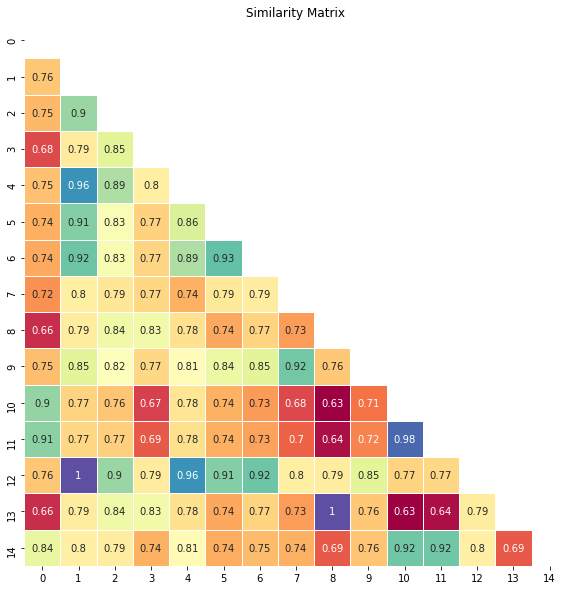

In [80]:
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True

#plt.figure(figsize=(16, 16),)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(matrix, 
                 linewidths=.5, 
                 square=True, annot=True, 
                 cmap='Spectral', 
                 mask=mask, 
                 cbar=False)
ax.set_title('Similarity Matrix')
#fig.savefig('test.svg', format='svg', dpi=1200)

In [81]:
sents[10], sents[13]

('Perennial forb and prairies; leaves alternate, long and narrow; flowers green, borne in axillary clusters.',
 'Face broad: width of the head/width of the face under the antennae: 1.91–2.08.')

In [29]:
sents[4], sents[1]

('Female thoracic dorsum with long, erect black to grey hairs.',
 'Male thorax and scutellar dorsum with a mixture of long and short hairs, varying from completely yellowish to a large portion of dark hairs.')

In [75]:
np.sum(matrix, axis=1)[15]

20.51213

In [99]:
sents[16]

'Symbol Key HIRTE Common Name hirtella'